In [100]:
#The eyetracker data analysis is based in AOI as blocks as seen in the image below. 
#Blocks are mapped 1-1 with the flowchart counterpart for the analysis however LOC or Token based analysis is also possible
#Some visual effort metrics are calculated below others can be derivated easily from the data

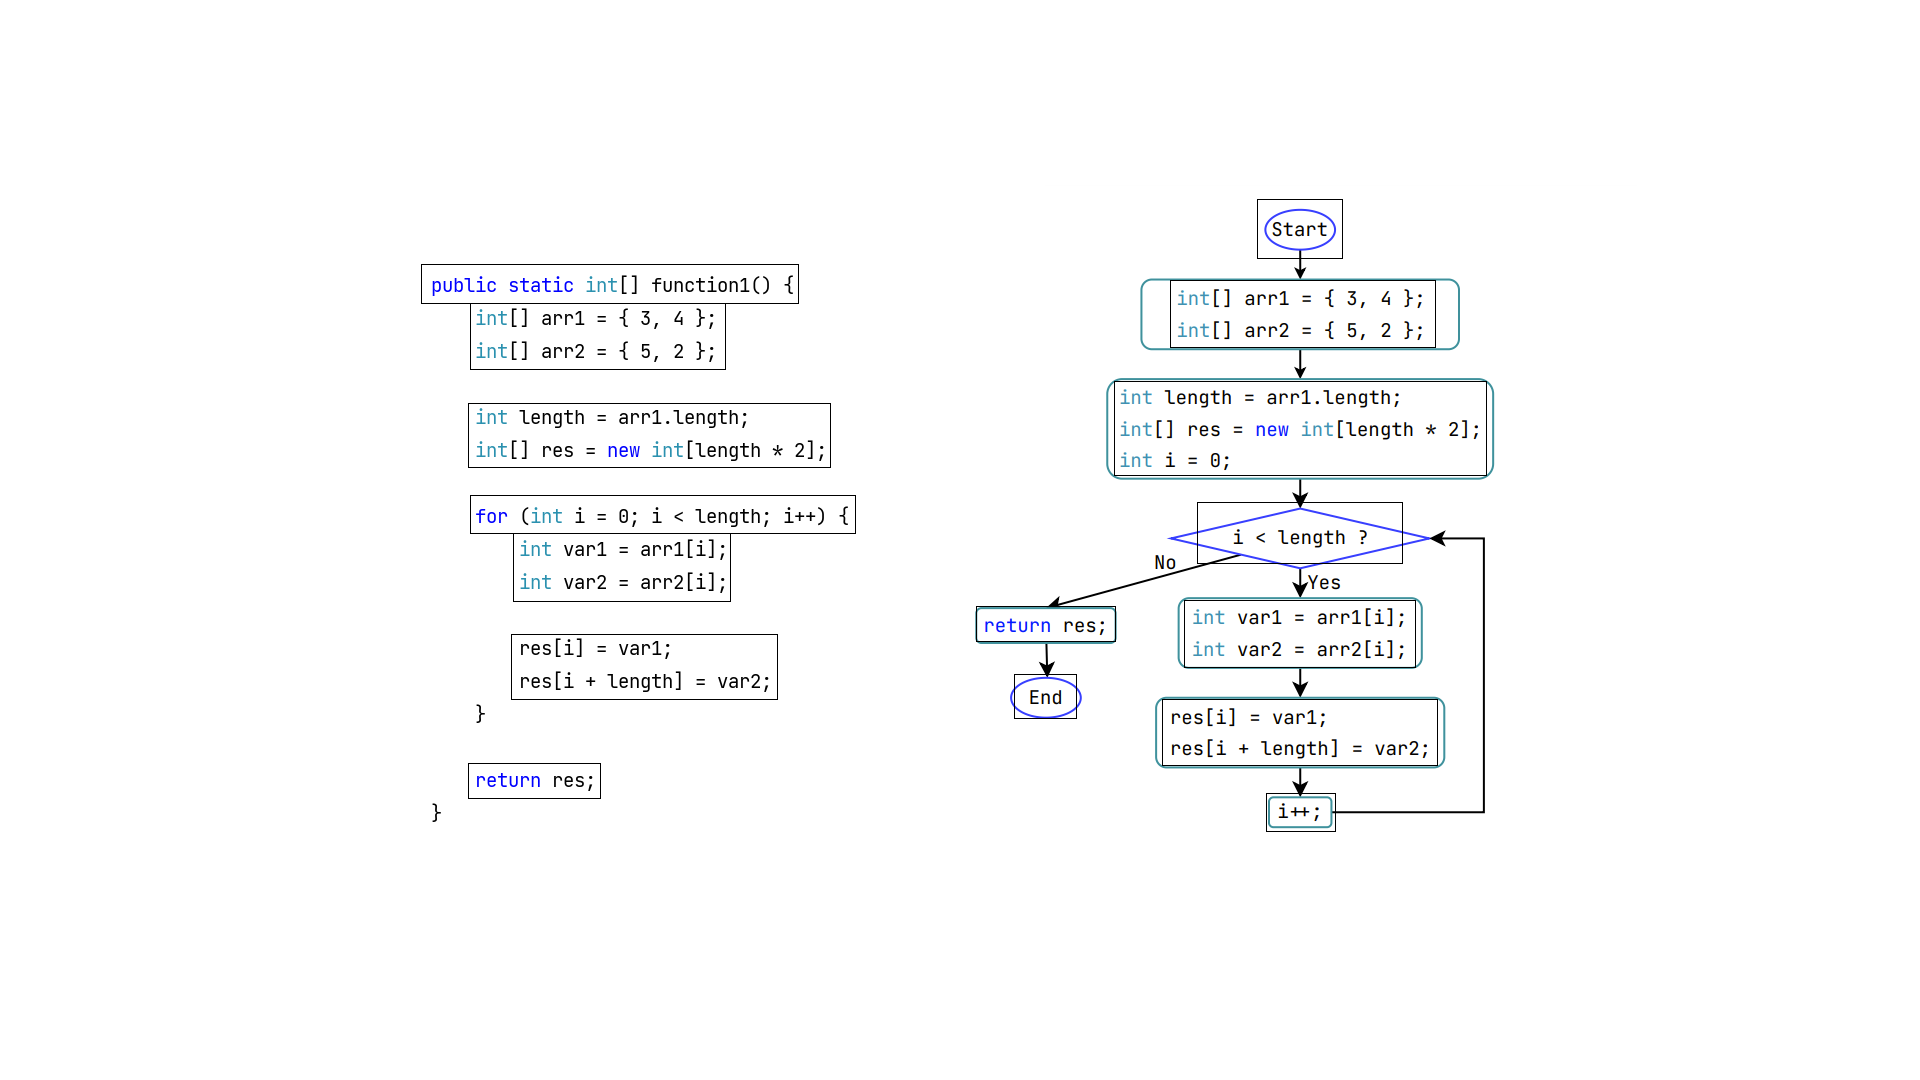

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from ast import literal_eval
import I2MC
import I2MC.plot
import matplotlib.pyplot as plt
import time 

In [5]:
opt = dict()
# General variables for eye-tracking data
# maximum value of horizontal resolution in pixels
opt['xres'] = 1920.0
opt['yres'] = 1080.0  # maximum value of vertical resolution in pixels
# missing value for horizontal position in eye-tracking data (example data uses -xres). used throughout
# internal_helpers as signal for data loss
opt['missingx'] = -opt['xres']
# missing value for vertical position in eye-tracking data (example data uses -yres). used throughout
# internal_helpers as signal for data loss
opt['missingy'] = -opt['yres']
# sampling frequency of data (check that this value matches with values actually obtained from measurement!)
opt['freq'] = 120.0

# Variables for the calculation of visual angle
# These values are used to calculate noise measures (RMS and BCEA) of
# fixations. The may be left as is, but don't use the noise measures then.
# If either or both are empty, the noise measures are provided in pixels
# instead of degrees.
# screen size in cm
opt['scrSz'] = [55.0, 32.5]
# distance to screen in cm.
opt['disttoscreen'] = 60.0
opt['downsampFilter'] = False

In [86]:
os.chdir("C:\\Users\\andres\\Music\\b\\experiment\\analysis")


# Setup Dataframe for storing fixation data
df_fixation = pd.DataFrame([], columns=["Participant", "Algorithm", "Behavioral", "StartTime", "EndTime", "Duration", "IsOutlier", "SkillScore",
                                        "Fixation_startT", "Fixation_endT",  "Fixation_x", "Fixation_y", "Fixation_x_range", "Fixation_y_range"])

eye_tracking_file="sample_data.csv"


# read in eyetracking file
df_eyetracking = pd.read_csv(eye_tracking_file)


# selecting rows based on code snippet and routine 
snippet = ['concatlists_flowchart.png'] 
routine = ['image'] 

df_eyetracking = df_eyetracking.loc[df_eyetracking['SNIPPET'].isin(snippet)] 
df_eyetracking = df_eyetracking.loc[df_eyetracking['ROUTINE'].isin(routine)] 

# normalize the time regarding eyetracking to 0
df_eyetracking["system_time_stamp"] = df_eyetracking["system_time_stamp"].astype(float)
df_eyetracking["system_time_stamp"] = df_eyetracking["system_time_stamp"] - df_eyetracking["system_time_stamp"].iloc[0]

# drop unused columns
df_eyetracking = df_eyetracking.drop(columns=["left_gaze_point_in_user_coordinate_system",
                                                  "right_gaze_point_in_user_coordinate_system",
                                                  "left_gaze_origin_in_user_coordinate_system",
                                                  "right_gaze_origin_in_user_coordinate_system",
                                                  "left_pupil_diameter",
                                                  "right_pupil_diameter","SNIPPET","ROUTINE"
                                               ])

# convert to none so python can process missing data
df_eyetracking["left_gaze_point_on_display_area"] = df_eyetracking["left_gaze_point_on_display_area"].apply(lambda x: str(x).replace('nan', 'None'))
df_eyetracking["right_gaze_point_on_display_area"] = df_eyetracking["right_gaze_point_on_display_area"].apply(lambda x: str(x).replace('nan', 'None'))


def string_to_tuple_left(data):
    data = literal_eval(str(data))
    if data[0] is not None:
        if data[0] < 0.48 :
           data= (-1920, -1080) 
    return data

def string_to_tuple_right(data):
    data = literal_eval(str(data))
    if data[0] is not None:
        if data[0] > 0.48 :
           data= (-1920, -1080) 
    return data

# select left and right gaze data depending on left right side 
df_eyetracking["left_gaze_point_on_display_area"] = df_eyetracking["left_gaze_point_on_display_area"].apply(string_to_tuple_left)
df_eyetracking["right_gaze_point_on_display_area"] = df_eyetracking["right_gaze_point_on_display_area"].apply(string_to_tuple_right)


# convert eyetracking data to display coordinates
df_eyetracking["l_display_x"] = df_eyetracking["left_gaze_point_on_display_area"].apply(lambda x: x[0] * opt["xres"] if x[0] is not None else None)
df_eyetracking["l_display_y"] = df_eyetracking["left_gaze_point_on_display_area"].apply(lambda x: x[1] * opt["yres"] if x[1] is not None else None)
df_eyetracking["r_display_x"] = df_eyetracking["right_gaze_point_on_display_area"].apply(lambda x: x[0] * opt["xres"] if x[0] is not None else None)
df_eyetracking["r_display_y"] = df_eyetracking["right_gaze_point_on_display_area"].apply(lambda x: x[1] * opt["yres"] if x[1] is not None else None)


# convert eyetracking data to I2MC valid flags
df_eyetracking["l_valid"] = df_eyetracking["left_gaze_point_validity"].astype(int)
df_eyetracking["r_valid"] = df_eyetracking["right_gaze_point_validity"].astype(int)

# convert miss column to right integer used by I2MC
df_eyetracking["l_miss_x"] = df_eyetracking.apply(lambda row: row["l_display_x"] < -opt["xres"] or row["l_display_x"] > 2 * opt["xres"], axis=1)
df_eyetracking["l_miss_y"] = df_eyetracking.apply(lambda row: row["l_display_y"] < -opt["yres"] or row["l_display_y"] > 2 * opt["yres"], axis=1)
df_eyetracking["r_miss_x"] = df_eyetracking.apply(lambda row: row["r_display_x"] < -opt["xres"] or row["r_display_x"] > 2 * opt["xres"], axis=1)
df_eyetracking["r_miss_y"] = df_eyetracking.apply(lambda row: row["r_display_y"] < -opt["yres"] or row["r_display_y"] > 2 * opt["yres"], axis=1)

df_eyetracking["l_miss"] = df_eyetracking.apply(lambda row: row["l_miss_x"] or row["l_miss_y"] or not row["l_valid"] >= 1, axis=1)
df_eyetracking["r_miss"] = df_eyetracking.apply(lambda row: row["r_miss_x"] or row["r_miss_y"] or not row["r_valid"] >= 1, axis=1)

# Set a default value for missing data
df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_x"] = opt["missingx"]
df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_y"] = opt["missingy"]
df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_x"] = opt["missingx"]
df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_y"] = opt["missingy"]



# drop unused columns
df_eyetracking = df_eyetracking.drop(columns=["l_miss_x", "l_miss_y", "r_miss_x", "r_miss_y", "l_miss", "r_miss","left_gaze_point_on_display_area","right_gaze_point_on_display_area","left_gaze_point_validity","right_gaze_point_validity","timestamp"])


# Transform time to ms
df_eyetracking["system_time_stamp"] = df_eyetracking["system_time_stamp"].astype(float) / 1000

# rename columns to match I2MC format
df_eyetracking.rename(columns={"l_display_x": "L_X",
                               "l_display_y": "L_Y",
                               "r_display_x": "R_X",
                               "r_display_y": "R_Y",
                               "l_valid" : "LValidity",
                               "r_valid" : "RValidity",
                               "system_time_stamp":"time"}, inplace=True)


print(df_eyetracking.head())

df_eyetracking.to_csv('parsed.csv', sep=',', index= False)

        time         L_X         L_Y     R_X     R_Y  LValidity  RValidity
9977   0.000  988.751221  491.767230 -1920.0 -1080.0          1          1
9978   8.376  988.794937  486.883410 -1920.0 -1080.0          1          1
9979  16.628  989.431458  486.887755 -1920.0 -1080.0          1          1
9980  24.987  994.514351  475.114928 -1920.0 -1080.0          1          1
9981  33.326  996.031952  478.834240 -1920.0 -1080.0          1          1


In [22]:
 

log_level=1

if log_level>0:
    print('    Running fixation classification...')
try:
    fix,_,_ = I2MC.I2MC(df_eyetracking,opt,log_level==2,logging_offset="      ")
except Exception as e:
    print('    Error in file {}: {}'.format(file_name, e))
    
    
if not fix:
    if log_level>0:
        print('    Fixation classification did not succeed with file {}'.format(file_name))

        
        
df_fixation_participant = pd.DataFrame(fix)        
print(df_fixation_participant.head())
df_fixation_participant.to_csv('fixations.csv', sep=',', index= False)


    Running fixation classification...
     cutoff  start  end    startT      endT      dur        xpos        ypos  \
0  1.916023      0   26     0.000   216.637  224.989  992.358971  489.446647   
1  1.916023     32   41   266.604   341.626   83.327  613.121080  339.779642   
2  1.916023     44  115   366.596   958.210  599.996  460.667095  288.340226   
3  1.916023    118  145   983.241  1208.194  233.276  504.080486  294.250474   
4  1.916023    150  179  1249.873  1491.490  249.979  545.414829  269.168188   

   flankdataloss  fracinterped     RMSxy      BCEA  fixRangeX  fixRangeY  
0            0.0      0.000000  0.218379  0.097261   0.289289   0.715608  
1            0.0      0.000000  0.308504  0.444472   0.910058   0.497308  
2            0.0      0.069444  0.500774  1.501498   2.129360   2.362383  
3            0.0      0.035714  0.353020  0.295028   0.555824   1.214034  
4            0.0      0.066667  0.331426  0.318592   0.840473   1.017618  


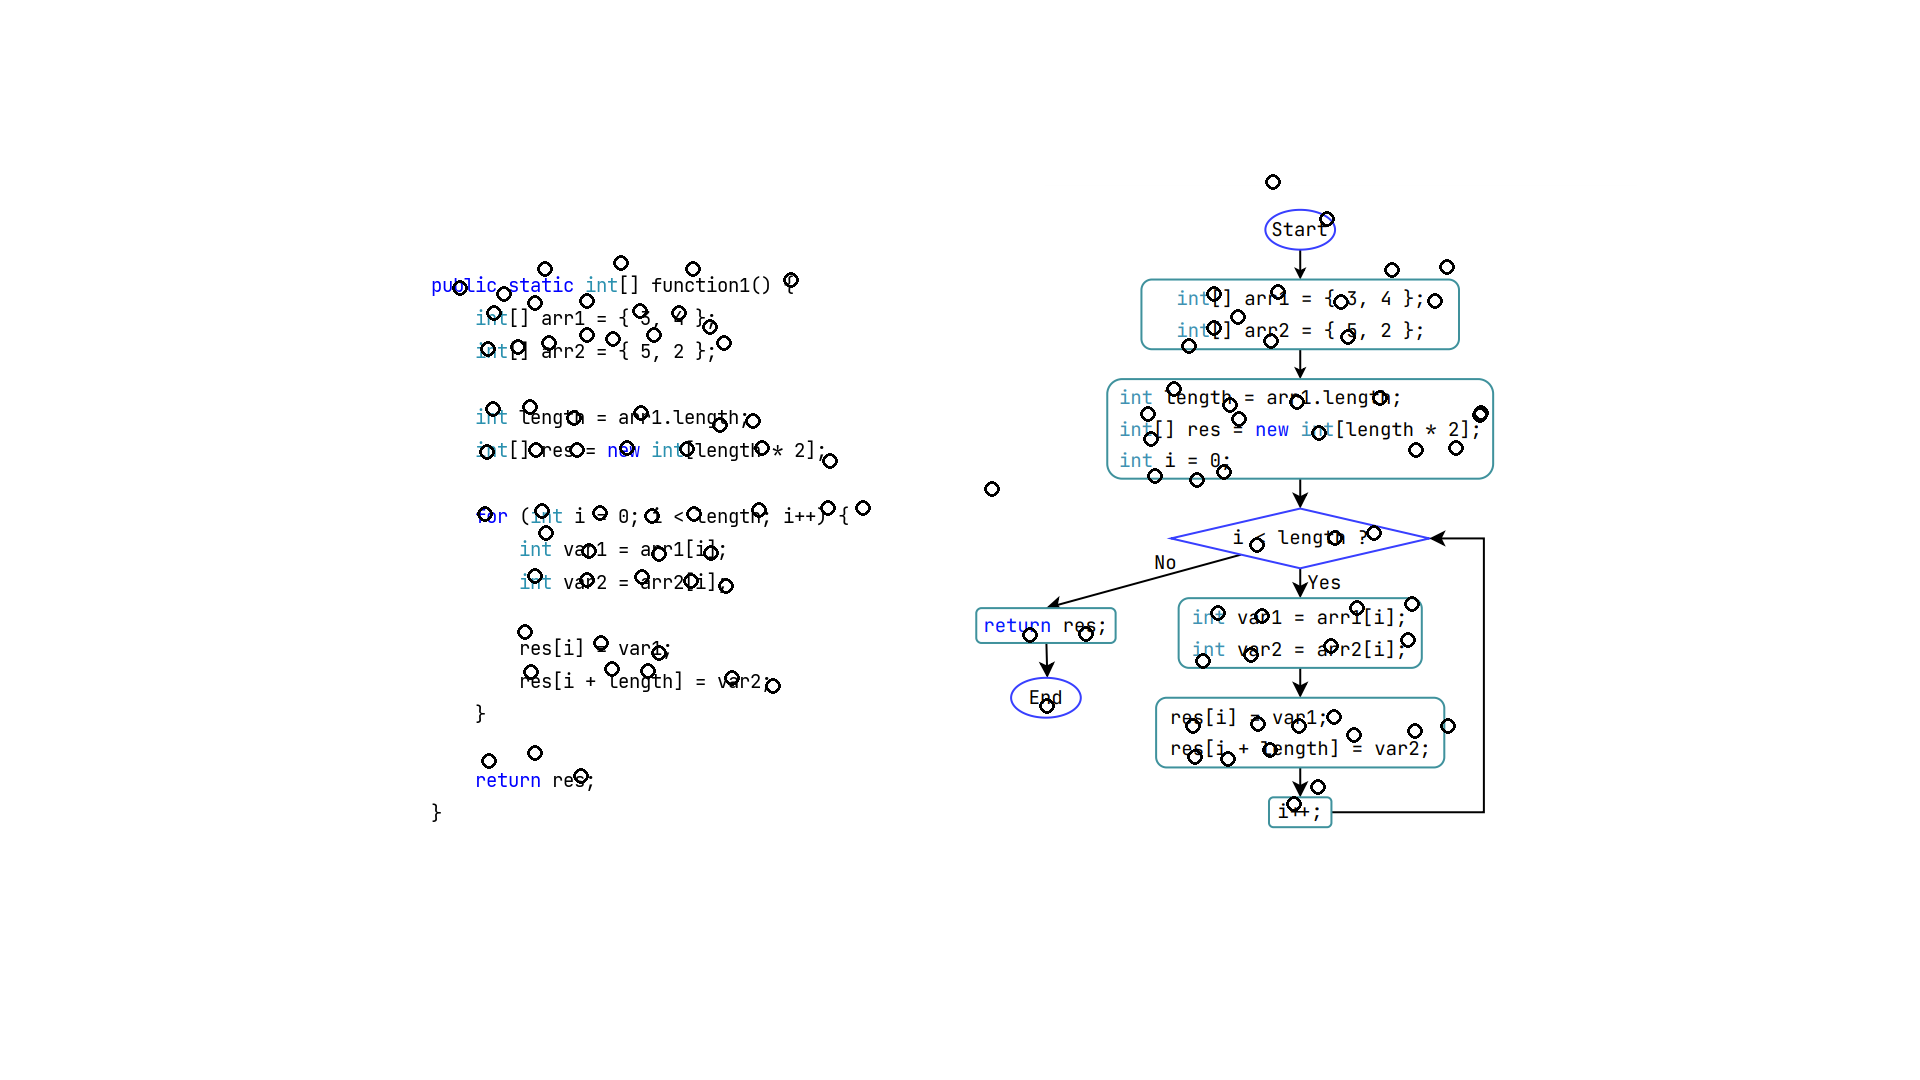

In [48]:
# The AOIs where generated manually
# There is a 1-1 mapping from AOIS in the code and in the flowchart

os.chdir("C:\\Users\\andres\\Music\\b\\experiment\\analysis")
import utils.GenSnippetsLib as gsl

df_aois = pd.read_csv('AOI.csv',sep=',')


df_aois


,Algorithm,AOI,AOIIdx,BoundingBox
0,concatlists_flowchart,method_signature_code,0,"(421, 262, 800, 300)"
1,concatlists_flowchart,inputs_code,1,"(469, 302, 725, 369)"
2,concatlists_flowchart,aux_vars_code,2,"(467, 402, 830, 467)"
3,concatlists_flowchart,for_head_code,3,"(469, 494, 855, 533)"
4,concatlists_flowchart,for_body_1_code,4,"(512, 532, 730, 601)"
5,concatlists_flowchart,for_body_2_code,5,"(510, 633, 777, 699)"
6,concatlists_flowchart,return_code,6,"(467, 762, 600, 798)"
7,concatlists_flowchart,start_flowchart,7,"(1256, 198, 1342, 258)"
8,concatlists_flowchart,inputs_flowchart,8,"(1169, 279, 1435, 347)"
9,concatlists_flowchart,aux_vars_flowchart,9,"(1113, 380, 1486, 475)"


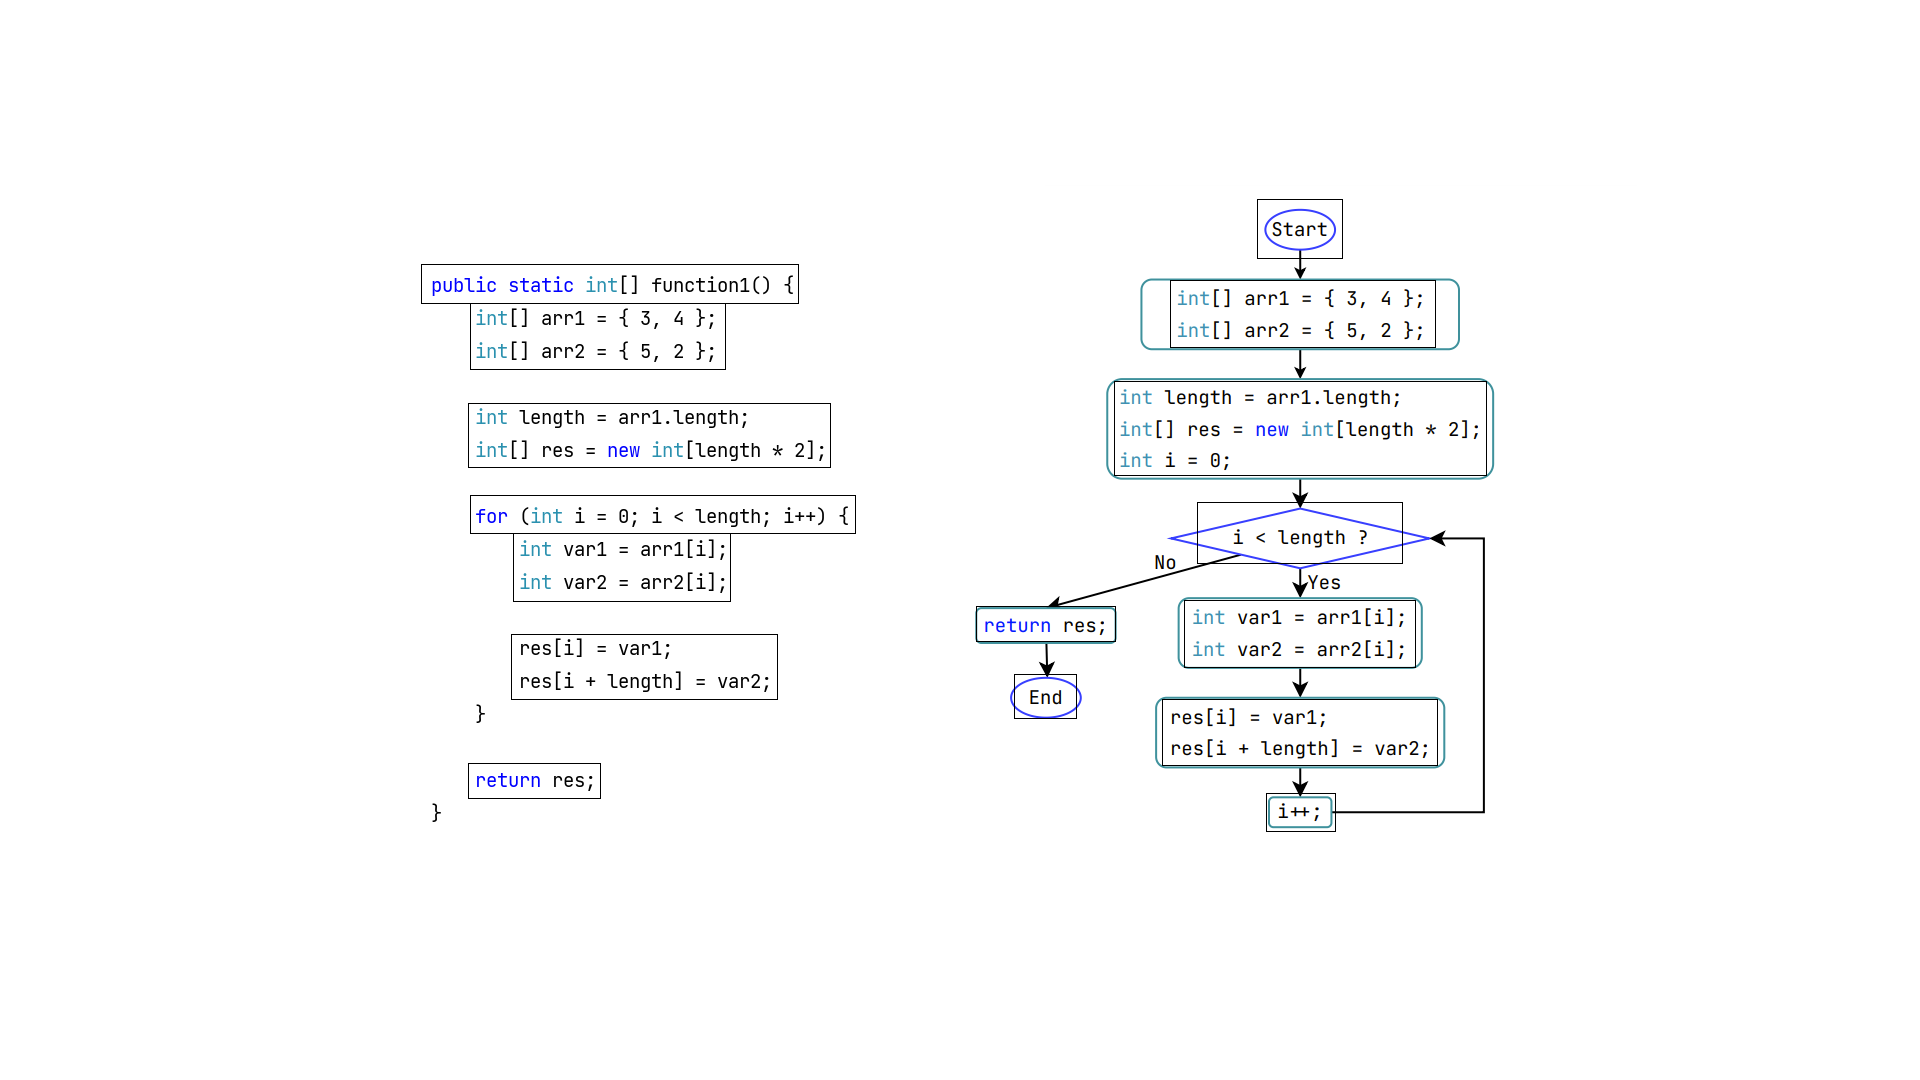

In [50]:
df_aoi_fixation_per_participant = pd.DataFrame([], columns=["Algorithm", "Participant", "FixationNumber",
                                                              "FixationDuration", "AOIIdx", "AOIName"])

import math
df_aois_per_algo = df_aois

start_times = df_fixation_participant["startT"].values
end_times = df_fixation_participant["endT"].values
x_coordinates = df_fixation_participant["xpos"].values
y_coordinates = df_fixation_participant["ypos"].values
x_range = df_fixation_participant["fixRangeX"].values
y_range = df_fixation_participant["fixRangeY"].values
idx_values = range(len(start_times))

for (fix_idx, start, end, x, y, x_range, y_range) in zip(idx_values, start_times, end_times, x_coordinates, y_coordinates, x_range, y_range):
    low_x = int(float(x) - math.ceil(float(x_range)))
    low_y = int(float(y) - math.ceil(float(y_range)))
    high_x = int(float(x) + math.ceil(float(x_range)))
    high_y = int(float(y) + math.ceil(float(y_range)))
    possible_coordinates = [(x, y) for x in range(low_x, high_x + 1) for y in range(low_y, high_y + 1)]

    for idx, row in df_aois_per_algo.iterrows():
        aoi_idx = row["AOIIdx"]
        aoi_name = row["AOI"]
        bounding_box = literal_eval(row["BoundingBox"])

        for possible_x, possible_y in possible_coordinates:
            if float(bounding_box[0]) <= possible_x <= float(bounding_box[2]) and float(bounding_box[1]) <= possible_y <= float(bounding_box[3]):
                df_aoi_fixation_per_participant.loc[len(df_aoi_fixation_per_participant)] = ["concatlists_flowchart", "participant", fix_idx ,end - start, aoi_idx, aoi_name]
                break
print(df_aoi_fixation_per_participant.head())
df_aoi_fixation_per_participant.to_csv('df_aoi_fixation_per_participant.csv', sep=',', index= False)

               Algorithm  Participant FixationNumber  FixationDuration AOIIdx  \
0  concatlists_flowchart  participant              1            75.022      1   
1  concatlists_flowchart  participant              2           591.614      0   
2  concatlists_flowchart  participant              3           224.953      0   
3  concatlists_flowchart  participant              4           241.617      0   
4  concatlists_flowchart  participant              5           358.328      0   

                 AOIName  
0            inputs_code  
1  method_signature_code  
2  method_signature_code  
3  method_signature_code  
4  method_signature_code  


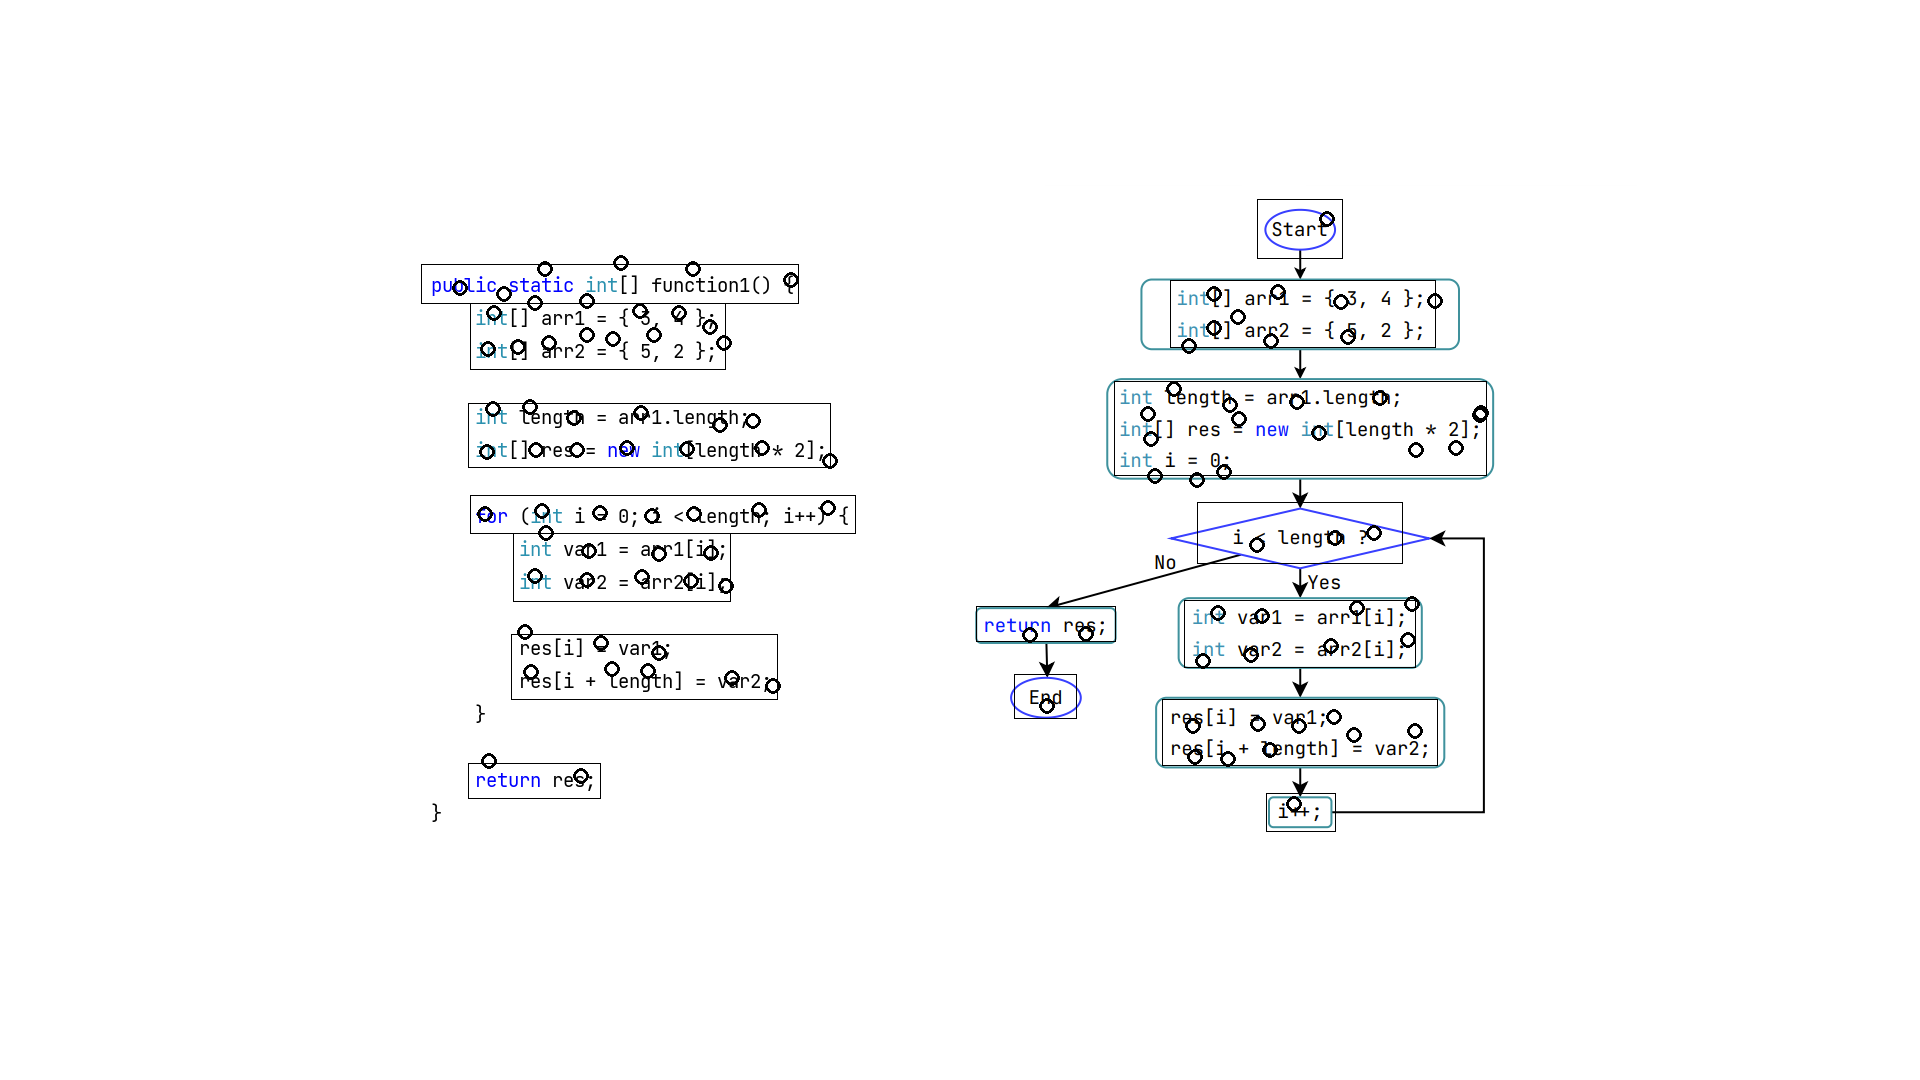

In [66]:
#METRICS
#Number of fixations in code and in flowchart
df=df_aoi_fixation_per_participant.copy()

count_total_fixations=len(df["FixationNumber"])

fixations_flowchart = df[df['AOIName'].str.endswith('flowchart')]
fixations_code = df[df['AOIName'].str.endswith('code')]

count_fixations_flowchart = len(fixations_flowchart)
count_fixations_code = len (fixations_code)
print("total fixations: "+str(count_total_fixations))
print("fixations over flowchart: "+str(count_fixations_flowchart))
print("fixations over code: "+str(count_fixations_code))



total fixations: 108
fixations over flowchart: 48
fixations over code: 60


In [69]:
#Number of fixations in each AOI
aoi_names= np.unique(df["AOIName"])

a=0
for aoi_name in aoi_names:
    df_aoi = df[df['AOIName']==aoi_name]
    print("fixations in "+aoi_name+": "+str(len(df_aoi)))

    


fixations in aux_vars_code: 13
fixations in aux_vars_flowchart: 14
fixations in end_flowchart: 1
fixations in for_body_1_code: 9
fixations in for_body_1_flowchart: 8
fixations in for_body_2_code: 8
fixations in for_body_2_flowchart: 9
fixations in for_counter_flowchart: 1
fixations in for_head_code: 8
fixations in for_head_flowchart: 3
fixations in inputs_code: 13
fixations in inputs_flowchart: 9
fixations in method_signature_code: 7
fixations in return_code: 2
fixations in return_flowchart: 2
fixations in start_flowchart: 1


In [75]:
#total fixation time in flowchart and code
time_fixations_flowchart=fixations_flowchart['FixationDuration'].sum()
time_fixations_code=fixations_code['FixationDuration'].sum()
print("total fixation time in flowchart (ms): "+str(time_fixations_flowchart))
print("total fixation time in code (ms): "+str(time_fixations_code))

total fixation time in flowchart (ms): 14515.480000000003
total fixation time in code (ms): 20398.600999999995


In [77]:
#total fixation ime in each aoi
for aoi_name in aoi_names:
    df_aoi = df[df['AOIName']==aoi_name]
    print("fixation time in flowchart in "+aoi_name+": "+str(df_aoi['FixationDuration'].sum()))


fixation time in flowchart in aux_vars_code: 3691.6200000000035
fixation time in flowchart in aux_vars_flowchart: 3266.374
fixation time in flowchart in end_flowchart: 349.9389999999985
fixation time in flowchart in for_body_1_code: 3333.126000000002
fixation time in flowchart in for_body_1_flowchart: 2333.2040000000125
fixation time in flowchart in for_body_2_code: 2857.9999999999927
fixation time in flowchart in for_body_2_flowchart: 2758.1509999999907
fixation time in flowchart in for_counter_flowchart: 449.9560000000056
fixation time in flowchart in for_head_code: 2416.557999999999
fixation time in flowchart in for_head_flowchart: 1033.2460000000028
fixation time in flowchart in inputs_code: 4657.962
fixation time in flowchart in inputs_flowchart: 3049.704999999998
fixation time in flowchart in method_signature_code: 2408.0879999999993
fixation time in flowchart in return_code: 1033.2469999999994
fixation time in flowchart in return_flowchart: 849.9469999999965
fixation time in flo

In [83]:
#transitions from code to flowchart or vice versa
past="test_code"
num_transitions=0
for index, row in df.iterrows():
    if row['AOIName'].split("_")[-1] != past.split("_")[-1]:
        num_transitions=num_transitions+1
    past=row['AOIName']
print(num_transitions)



1


In [ ]:
#transitions from related AOIS - for instance from "for_block_code" to "for_block_flowchart"
